In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import polars as ps
import seaborn as sb
import pymc3 as pm
from theano import shared, tensor
import arviz as az

WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
dataset: ps.DataFrame = ps.read_csv('full_dataset.csv', encoding='utf8')

In [3]:
dataset

SiteId,PublishTime,AQI,Pollutant,Status,SO2,SO2_AVG,CO,CO_8hr,O3,O3_8hr,PM10,PM10_AVG,NO,NO2,NOx,WindDirec,WindSpeed,PM2.5,PM2.5_AVG
i64,str,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64
17,"""2021-01-01T00:…",55,0,1,3.8,1.0,0.5,0.5,16.1,21.0,29.0,32.0,2.8,16.7,19.5,72,2.0,22.0,17.0
20,"""2021-01-01T01:…",68,0,1,3.5,2.0,0.4,0.4,20.9,22.0,52.0,39.0,1.5,14.0,15.5,65,3.2,36.0,22.0
11,"""2021-01-01T01:…",50,0,0,1.8,2.0,0.2,0.2,33.1,31.0,25.0,25.0,0.0,4.4,4.1,68,1.8,14.0,15.0
10,"""2021-01-01T02:…",49,0,0,1.7,1.0,0.3,0.3,29.1,31.0,24.0,30.0,0.3,4.1,4.1,990,0.3,15.0,15.0
39,"""2021-01-01T02:…",72,0,1,1.8,1.0,0.3,0.3,18.5,20.0,29.0,36.0,1.1,10.3,11.4,358,2.5,18.0,24.0
78,"""2021-01-01T03:…",63,0,1,2.3,3.0,0.2,0.2,36.4,36.0,35.0,30.0,0.0,2.1,1.9,16,5.8,22.0,20.0
62,"""2021-01-01T04:…",48,0,0,1.2,1.0,0.3,0.3,29.8,28.0,17.0,21.0,1.3,4.0,5.3,321,3.0,11.0,15.0
48,"""2021-01-01T04:…",82,0,1,2.8,2.0,0.4,0.4,4.8,6.0,40.0,48.0,1.4,18.2,19.6,23,2.6,27.0,28.0
61,"""2021-01-01T05:…",34,0,0,1.2,1.0,0.2,0.2,36.8,37.0,13.0,13.0,0.9,1.3,2.2,26,6.3,9.0,9.0


C:\Users\user\AppData\Local\Temp\ipykernel_14956\2620947190.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sb.heatmap(dataset.to_pandas().corr(), annot=True)


<Axes: >

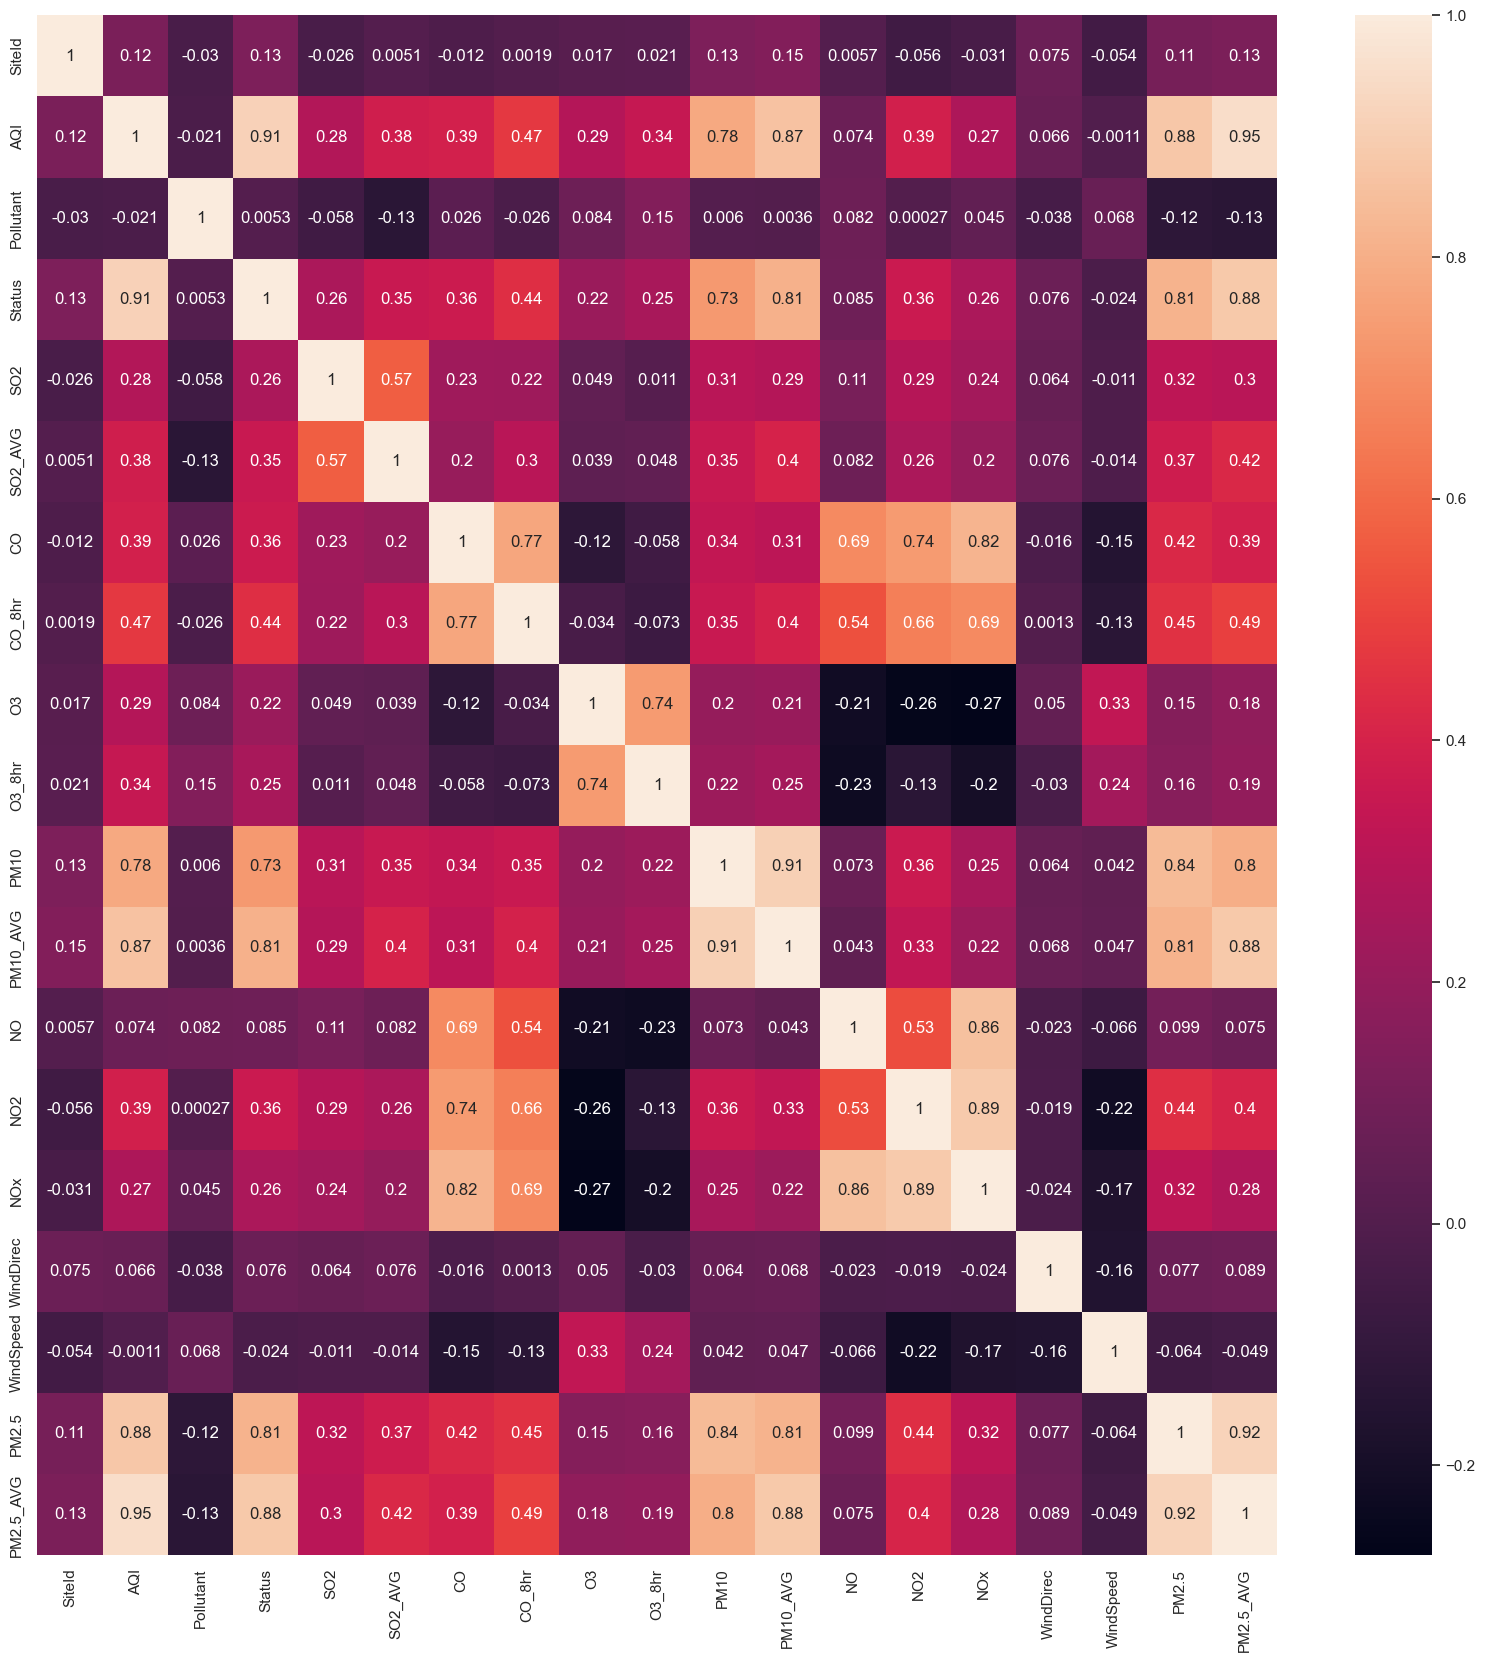

In [4]:
sb.set(rc={'figure.figsize': (20, 20)})
sb.heatmap(dataset.to_pandas().corr(), annot=True)

In [5]:
features: list = ['AQI', 'Status', 'PM10', 'PM10_AVG', 'PM2.5_AVG']

In [6]:
variables: list = [shared(dataset[feature].to_numpy(writable=True)) for feature in features]

In [7]:
target = dataset['PM2.5'].to_numpy(writable=True)

In [8]:
dataset[features]

AQI,Status,PM10,PM10_AVG,PM2.5_AVG
i64,i64,f64,f64,f64
55,1,29.0,32.0,17.0
68,1,52.0,39.0,22.0
50,0,25.0,25.0,15.0
49,0,24.0,30.0,15.0
72,1,29.0,36.0,24.0
63,1,35.0,30.0,20.0
48,0,17.0,21.0,15.0
82,1,40.0,48.0,28.0
34,0,13.0,13.0,9.0


In [9]:
len(target)

1218300

In [10]:
with pm.Model() as predictor:
    α = pm.Normal("α", sd=10)
    β = pm.Normal('β', mu=0, sd=1, shape=5) 
    ε = pm.HalfCauchy('ε', 5)
    μ = α + pm.math.dot(dataset[features][:100000], β)
    # model = pm.Deterministic('model', (intercept + (coefficients[i] * variables[i] for i in range(5))))
    # prediction = pm.Normal(name='prediction', mu=model, sigma=error, observed=target)
    y_pred = pm.Normal('y_pred', mu=μ, sd=ε, observed=target[:100000])

    trace = pm.sample(tune=2000, chains=2, cores=2)
    ppc = pm.sample_posterior_predictive(trace, samples=2000)

C:\Users\user\anaconda3\envs\pm3env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ε, β, α]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 924 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\user\anaconda3\envs\pm3env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<Axes: title={'center': 'α'}>, <Axes: title={'center': 'α'}>],
       [<Axes: title={'center': 'β'}>, <Axes: title={'center': 'β'}>],
       [<Axes: title={'center': 'ε'}>, <Axes: title={'center': 'ε'}>]],
      dtype=object)

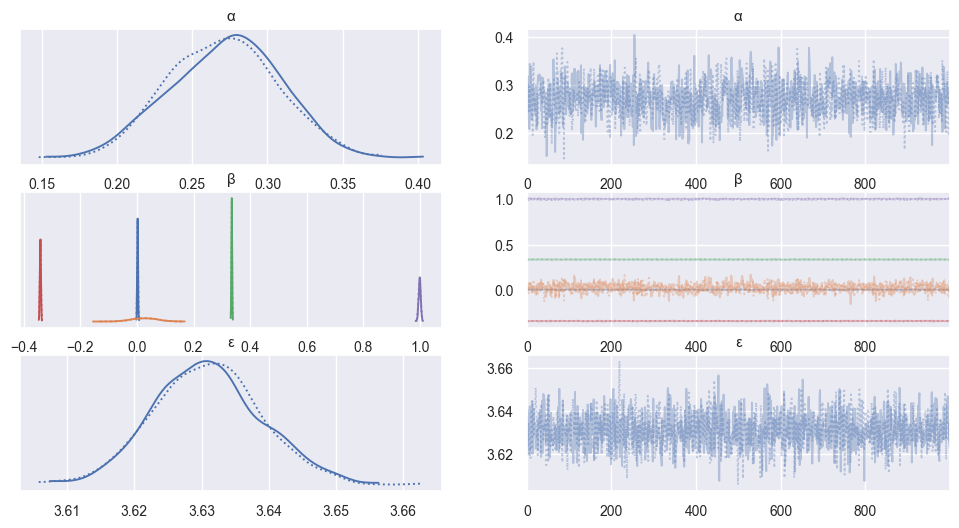

In [11]:
az.plot_trace(trace, var_names = ["α","β",'ε'])

In [12]:
az.summary(trace, var_names=["α","β",'ε'])

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\user\anaconda3\envs\pm3env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,0.271,0.037,0.203,0.336,0.001,0.001,1028.0,1171.0,1.0
β[0],0.002,0.002,-0.001,0.005,0.000,0.000,891.0,1050.0,1.0
β[1],0.026,0.045,-0.052,0.116,0.001,0.001,1081.0,1188.0,1.0
β[2],0.335,0.001,0.333,0.337,0.000,0.000,1672.0,1469.0,1.0
β[3],-0.341,0.002,-0.345,-0.338,0.000,0.000,1575.0,1236.0,1.0
β[4],0.999,0.004,0.992,1.006,0.000,0.000,1323.0,938.0,1.0
ε,3.631,0.008,3.616,3.646,0.000,0.000,1665.0,1440.0,1.0


In [37]:
with pm.Model() as predictor2:
    α = pm.Normal("α", sd=10)
    β = pm.Normal('β', mu=0, sd=1) 
    ε = pm.HalfCauchy('ε', 5)
    μ = α + pm.math.dot(dataset['AQI'][:100000], β)
    # model = pm.Deterministic('model', (intercept + (coefficients[i] * variables[i] for i in range(5))))
    # prediction = pm.Normal(name='prediction', mu=model, sigma=error, observed=target)
    y_pred = pm.Normal('y_pred', mu=μ, sd=ε, observed=target[:100000])

    trace = pm.sample(tune=2000, chains=2, cores=2)
    ppc = pm.sample_posterior_predictive(trace, samples=2000)

C:\Users\user\anaconda3\envs\pm3env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ε, β, α]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 44 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\user\anaconda3\envs\pm3env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<Axes: title={'center': 'α'}>, <Axes: title={'center': 'α'}>],
       [<Axes: title={'center': 'β'}>, <Axes: title={'center': 'β'}>],
       [<Axes: title={'center': 'ε'}>, <Axes: title={'center': 'ε'}>]],
      dtype=object)

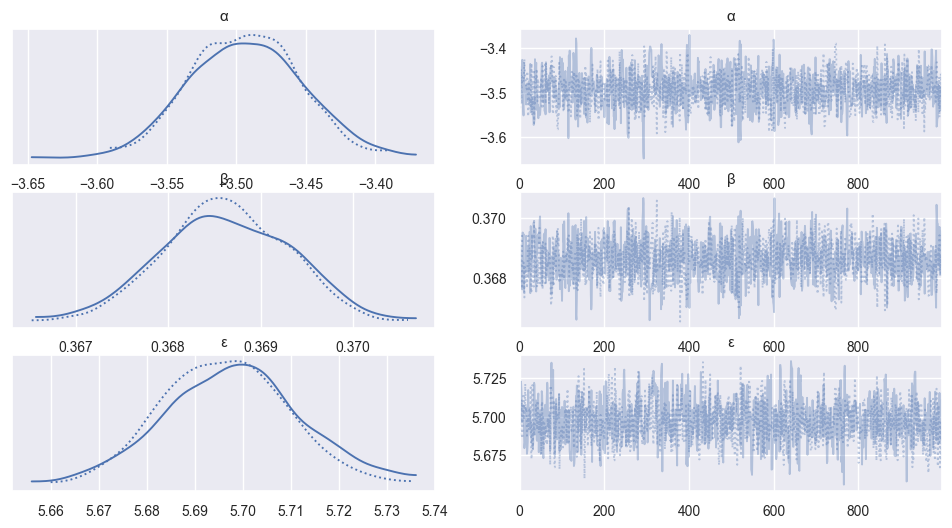

In [38]:
az.plot_trace(trace, var_names = ["α","β",'ε'])

In [39]:
az.summary(trace, var_names=["α","β",'ε'])

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\user\anaconda3\envs\pm3env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-3.493,0.040,-3.565,-3.420,0.001,0.001,1083.0,1033.0,1.00
β,0.369,0.001,0.367,0.370,0.000,0.000,1090.0,885.0,1.01
ε,5.697,0.013,5.672,5.722,0.000,0.000,1085.0,926.0,1.00


C:\Users\user\anaconda3\envs\pm3env\lib\site-packages\arviz\plots\hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
C:\Users\user\anaconda3\envs\pm3env\lib\site-packages\arviz\plots\hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


Text(0, 0.5, 'pm2.5')

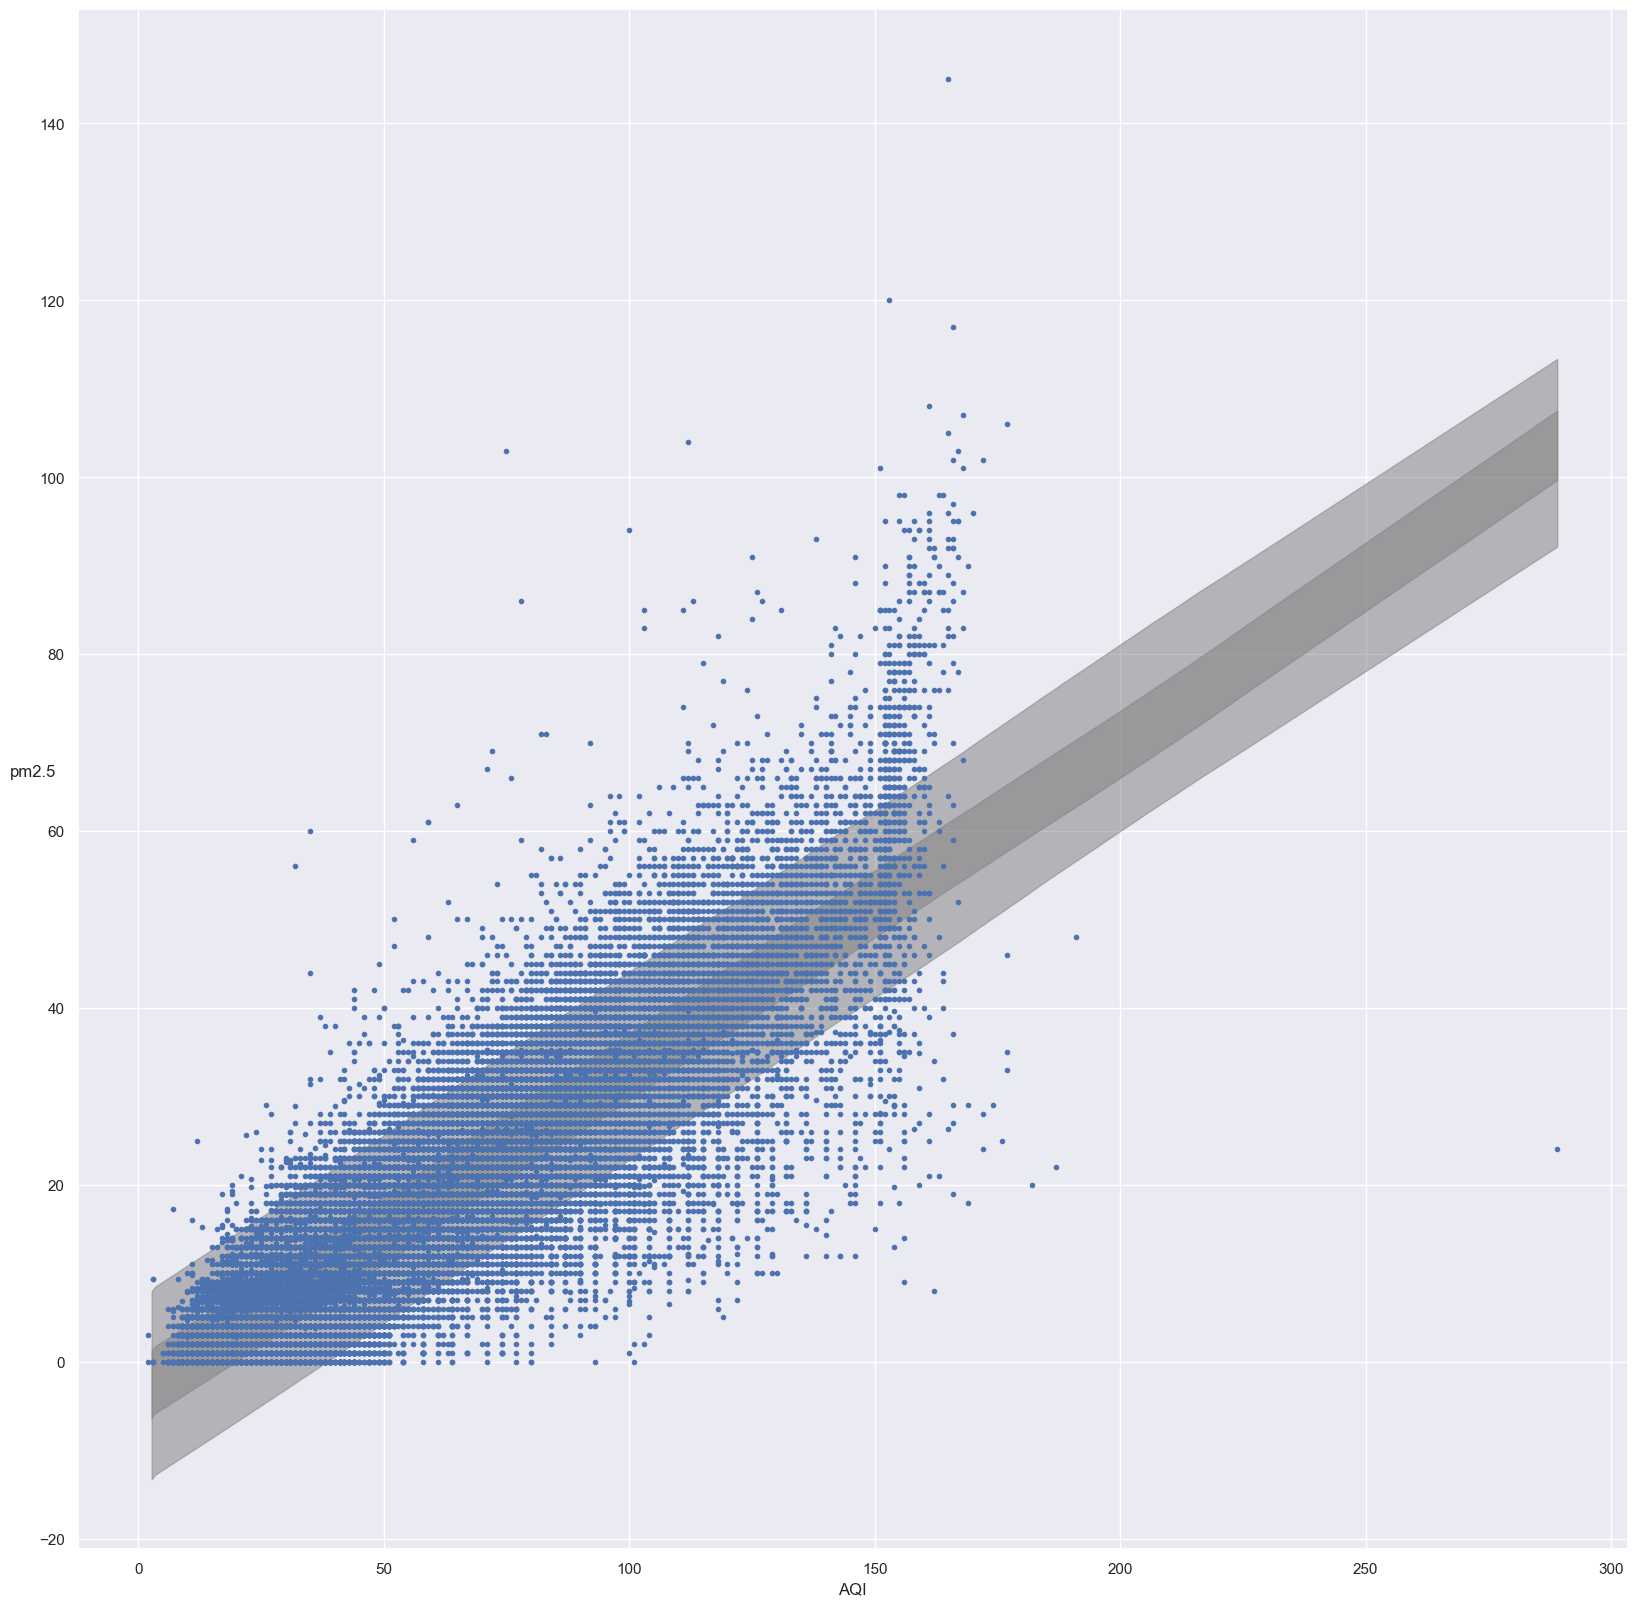

In [47]:
plt.plot(dataset['AQI'][:100000], target[:100000], 'b.')
plt.plot(target[:100000].mean(), trace['α'].mean() + trace['β'].mean()* dataset['AQI'][:100000].mean(), c='k')
az.plot_hdi(dataset['AQI'][:100000], ppc['y_pred'], hdi_prob=0.5, color='gray')
az.plot_hdi(dataset['AQI'][:100000], ppc['y_pred'], color='gray')
plt.xlabel('AQI')
plt.ylabel('pm2.5', rotation=0)

In [48]:
with pm.Model() as predictor2:
    α = pm.Normal("α", sd=10)
    β = pm.Normal('β', mu=0, sd=1) 
    ε = pm.HalfCauchy('ε', 5)
    μ = α + pm.math.dot(dataset['AQI'][:100000], β)
    # model = pm.Deterministic('model', (intercept + (coefficients[i] * variables[i] for i in range(5))))
    # prediction = pm.Normal(name='prediction', mu=model, sigma=error, observed=target)
    # y_pred = pm.Normal('y_pred', mu=μ, sd=ε, observed=target[:100000])
    
    ν_ = pm.Exponential('ν_', 1/29)
    ν = pm.Deterministic('ν', ν_ + 1)
    y_pred = pm.StudentT('y_pred', mu=μ, sd=ε, nu=ν, observed=target[:100000]) 

    trace = pm.sample(tune=2000, chains=2, cores=2)
    ppc = pm.sample_posterior_predictive(trace, samples=2000)

C:\Users\user\anaconda3\envs\pm3env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν_, ε, β, α]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 222 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\user\anaconda3\envs\pm3env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<Axes: title={'center': 'α'}>, <Axes: title={'center': 'α'}>],
       [<Axes: title={'center': 'β'}>, <Axes: title={'center': 'β'}>],
       [<Axes: title={'center': 'ε'}>, <Axes: title={'center': 'ε'}>]],
      dtype=object)

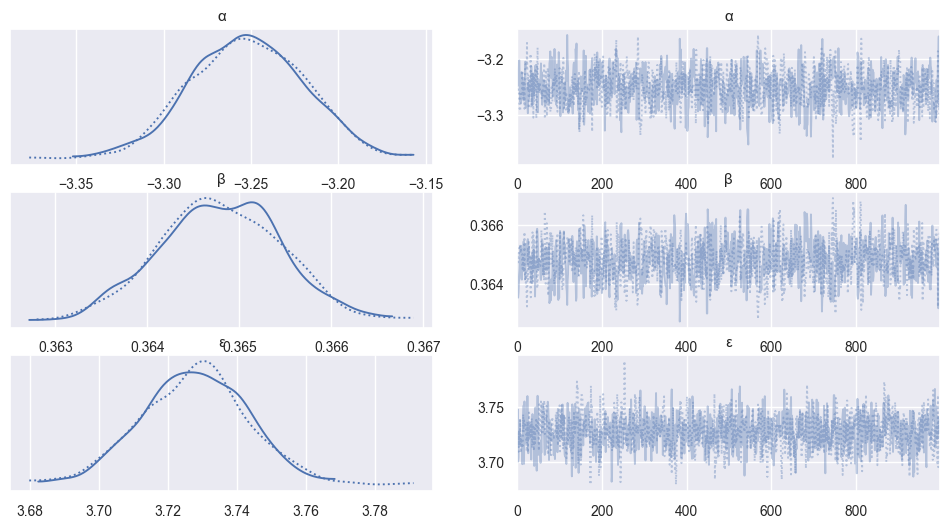

In [49]:
az.plot_trace(trace, var_names = ["α","β",'ε'])

In [50]:
az.summary(trace, var_names=["α","β",'ε'])

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\user\anaconda3\envs\pm3env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-3.252,0.032,-3.309,-3.194,0.001,0.001,811.0,1036.0,1.0
β,0.365,0.001,0.364,0.366,0.000,0.000,845.0,978.0,1.0
ε,3.728,0.015,3.700,3.757,0.000,0.000,1176.0,1319.0,1.0


C:\Users\user\anaconda3\envs\pm3env\lib\site-packages\arviz\plots\hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
C:\Users\user\anaconda3\envs\pm3env\lib\site-packages\arviz\plots\hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


Text(0, 0.5, 'pm2.5')

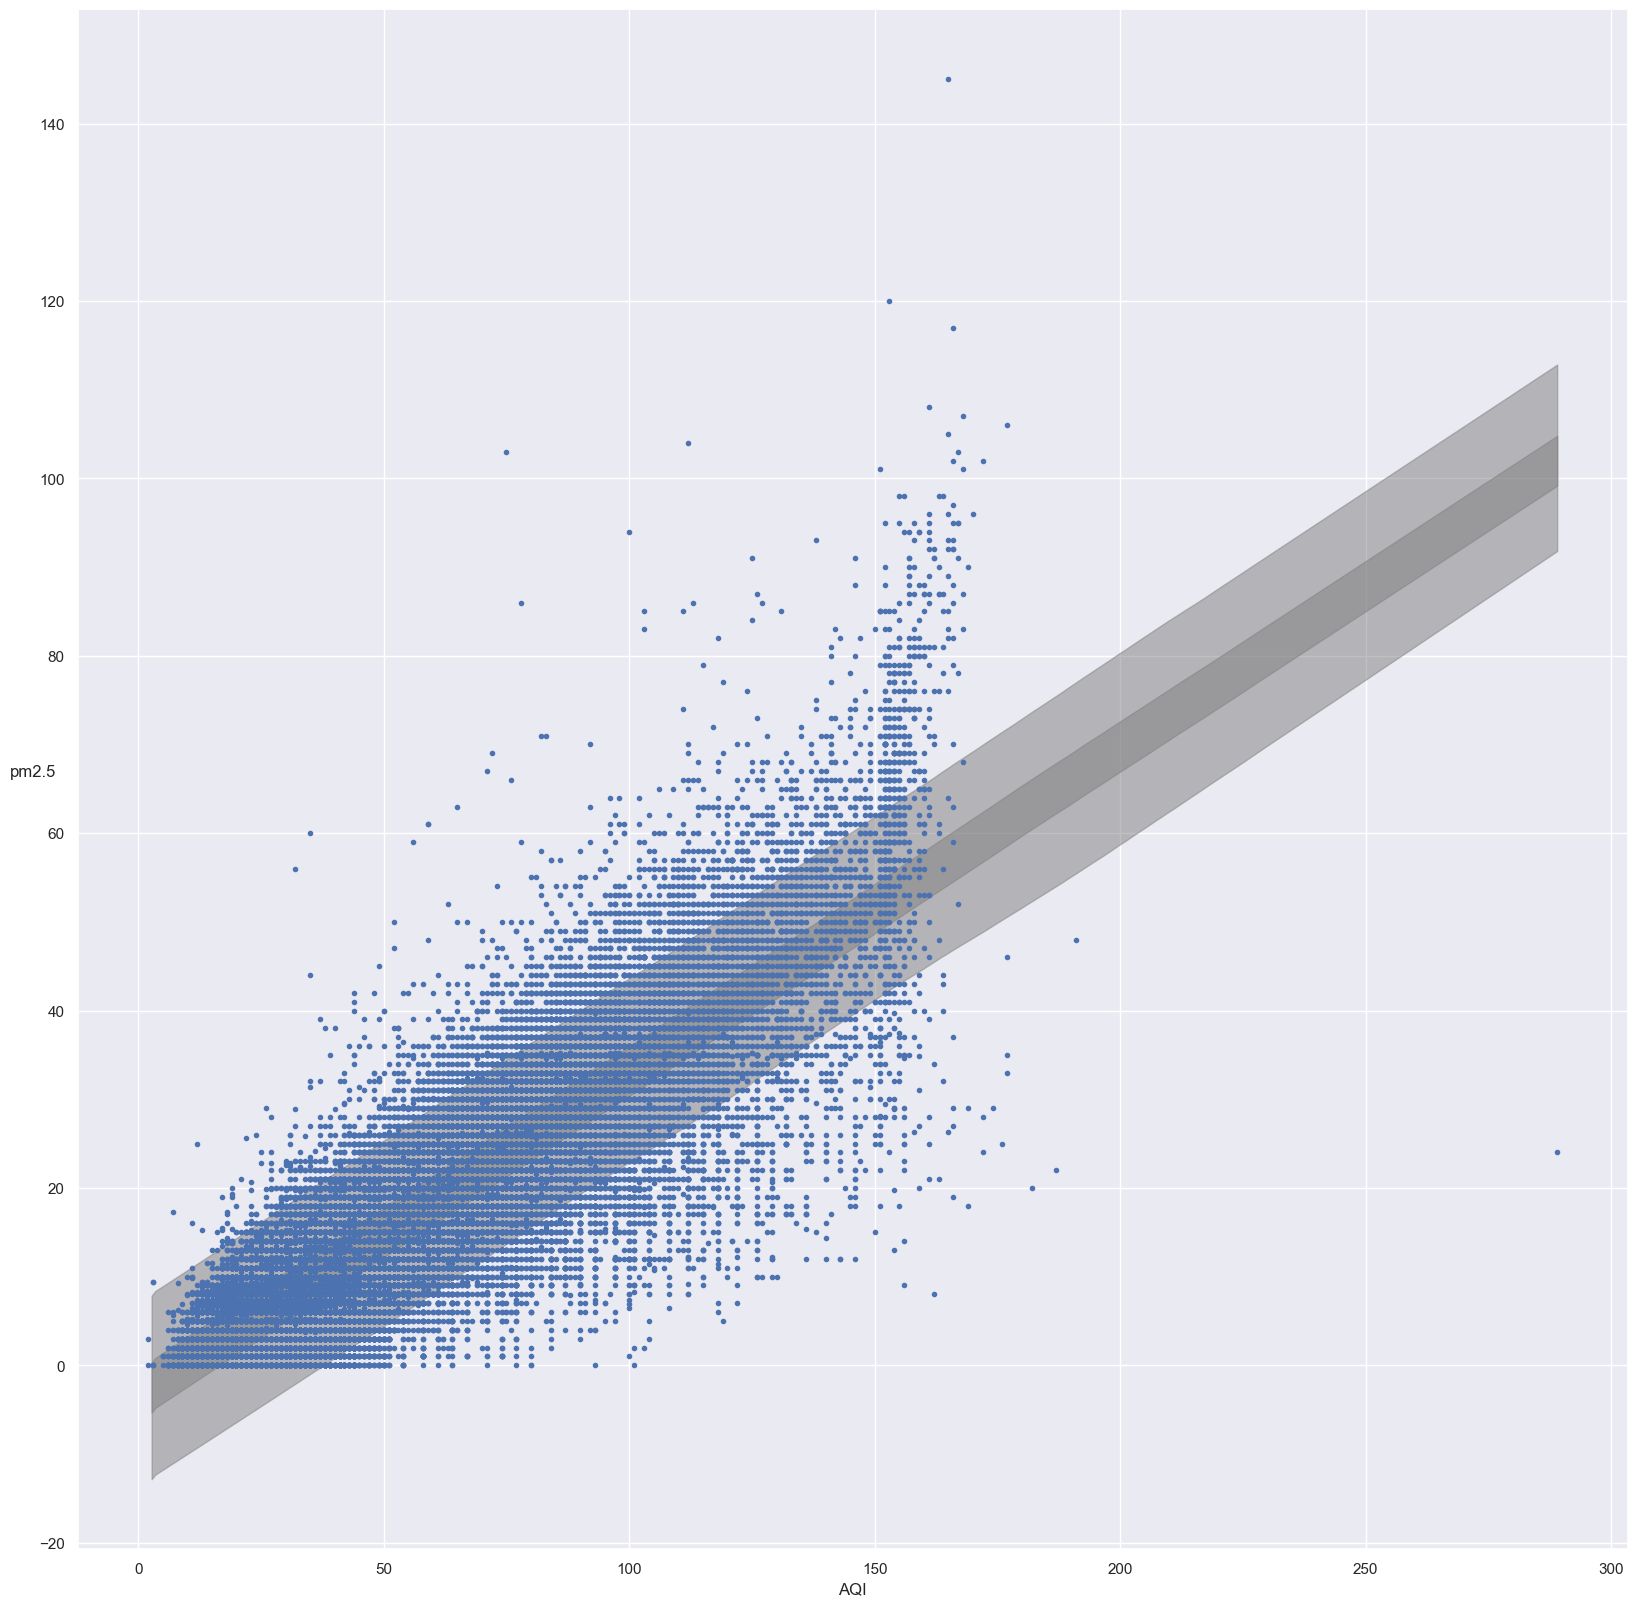

In [51]:
plt.plot(dataset['AQI'][:100000], target[:100000], 'b.')
plt.plot(target[:100000].mean(), trace['α'].mean() + trace['β'].mean()* dataset['AQI'][:100000].mean(), c='k')
az.plot_hdi(dataset['AQI'][:100000], ppc['y_pred'], hdi_prob=0.5, color='gray')
az.plot_hdi(dataset['AQI'][:100000], ppc['y_pred'], color='gray')
plt.xlabel('AQI')
plt.ylabel('pm2.5', rotation=0)

In [13]:
dataset = dataset.with_columns(ps.col('PublishTime').dt.year().alias('PublishYear'))
dataset = dataset.with_columns(ps.col('PublishTime').dt.month().alias('PublishMonth'))
dataset = dataset.with_columns(ps.col('PublishTime').dt.day().alias('PublishDay'))
dataset = dataset.with_columns(ps.col('PublishTime').dt.hour().alias('PublishHour'))

InvalidOperationError: `year` operation not supported for dtype `str`

In [97]:
dataset = dataset.drop(['SiteName', 'County', 'PublishTime', 'PublishYearAndMonth', 'Longitude', 'Latitude'])
dataset = dataset.unique()
dataset = dataset[
    ['SiteId', 'PublishYear', 'PublishMonth', 'PublishDay', 'PublishHour', 'AQI', 'Pollutant', 'Status', 'SO2',
     'SO2_AVG', 'CO', 'CO_8hr', 'O3', 'O3_8hr', 'PM10',
     'PM10_AVG', 'NO', 'NO2', 'NOx', 'WindDirec', 'WindSpeed', 'PM2.5', 'PM2.5_AVG']]

In [98]:
dataset

SiteId,PublishYear,PublishMonth,PublishDay,PublishHour,AQI,Pollutant,Status,SO2,SO2_AVG,CO,CO_8hr,O3,O3_8hr,PM10,PM10_AVG,NO,NO2,NOx,WindDirec,WindSpeed,PM2.5,PM2.5_AVG
i32,i32,u32,u32,u32,i32,i32,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i32,f32,f32,f32
10,2021,1,1,0,47,0,0,1.1,1.0,0.2,0.3,32.799999,30.0,33.0,31.0,0.6,4.3,4.9,50,1.9,16.0,14.0
7,2021,1,1,0,55,0,1,1.4,2.0,0.3,0.4,29.700001,23.0,25.0,31.0,2.9,8.3,11.3,59,3.3,12.0,17.0
10,2021,1,1,0,47,0,0,1.1,1.0,0.2,0.3,32.799999,30.0,33.0,31.0,0.6,4.3,4.9,92,2.5,16.0,14.0
20,2021,1,1,3,69,0,1,4.8,2.0,0.4,0.4,20.700001,22.0,38.0,37.0,1.8,11.9,13.7,68,3.1,22.0,23.0
31,2021,1,1,3,57,0,1,1.9,2.0,0.3,0.3,22.6,22.0,23.0,26.0,0.7,8.8,9.4,52,1.4,16.0,18.0
25,2021,1,1,4,52,0,1,2.3,2.0,0.3,0.3,28.200001,27.0,32.0,31.0,0.8,7.7,8.4,53,2.7,14.0,16.0
67,2021,1,1,4,55,0,1,1.4,3.0,0.5,0.8,31.200001,31.1,23.0,31.0,18.700001,19.5,38.200001,92,2.5,11.0,17.0
10,2021,1,1,4,43,0,0,1.5,1.0,0.2,0.2,33.799999,32.0,24.0,26.0,0.3,2.8,2.9,50,1.4,13.0,13.0
67,2021,1,1,5,50,0,0,1.6,3.0,0.5,0.8,31.200001,31.1,24.0,28.0,17.700001,19.200001,36.900002,92,2.5,13.0,15.0
